# 🎮 1D Playground: Diffusion & Flow Matching Sanity Checks

This notebook provides interactive 1D experiments to build intuition for diffusion models and flow matching.

**Why 1D?**
- Ultra-fast training (in seconds & CPU friendly)
- Easy to visualize distributions and flows
- Perfect for debugging and understanding

**Note:** You should be able to use this notebook with CPU only machines.

If you are using VSCode and you do not see your venv in the kernel options, first activate your venv in your terminal and run 

'''

uv run --active python -m ipykernel install --user --name cmu-10799 --display-name "Python (cmu-10799)"

'''

In VS Code:
- Command Palette → Python: Select Interpreter → pick .venv-(your env)/bin/python
- In the notebook → Select Kernel → pick .venv-(your env) or Python (cmu-10799-cpu)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Create 1D Mixture of Gaussians

In [2]:
def get_1d_data(name, n_samples=10000):
    """Generate 1D mixture of Gaussians datasets with different weights."""
    if name == '2gaussians':
        # Two Gaussians at -2 and 2 (equal weights)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        # Three Gaussians at -2, 0, 2 (equal weights)
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        # Five evenly spaced Gaussians (equal weights)
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        # Uneven mixture with different spacing (equal weights)
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        # Wider Gaussians (equal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        # Two Gaussians with different weights (tall left, short right)
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        # Three Gaussians with different weights (tall-short-medium)
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        # Five Gaussians with varied weights
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        # Wider Gaussians (unequal weights)
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Sample from each Gaussian according to weights
    X = []
    for center, weight in zip(centers, weights):
        n_samples_for_center = int(n_samples * weight)
        samples = np.random.randn(n_samples_for_center, 1) * std + center
        X.append(samples)
    X = np.concatenate(X, axis=0)
    
    # Shuffle
    np.random.shuffle(X)
    
    return torch.tensor(X, dtype=torch.float32)


def get_ground_truth_density(name, x_values):
    """Compute the ground truth density for a given dataset at x_values."""
    if name == '2gaussians':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.5, 0.5]
    elif name == '3gaussians':
        centers = [-2.0, 0.0, 2.0]
        std = 0.3
        weights = [1/3, 1/3, 1/3]
    elif name == '5gaussians':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elif name == 'uneven':
        centers = [-3.5, -1.0, 0.5, 2.5]
        std = 0.3
        weights = [0.25, 0.25, 0.25, 0.25]
    elif name == 'wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.5, 0.5]
    elif name == 'weighted2':
        centers = [-2.0, 2.0]
        std = 0.3
        weights = [0.8, 0.2]
    elif name == 'weighted3':
        centers = [-2.5, 0.0, 2.5]
        std = 0.3
        weights = [0.5, 0.2, 0.3]
    elif name == 'weighted5':
        centers = [-3.0, -1.5, 0.0, 1.5, 3.0]
        std = 0.25
        weights = [0.1, 0.15, 0.4, 0.25, 0.1]
    elif name == 'weighted_wide':
        centers = [-2.0, 2.0]
        std = 0.8
        weights = [0.65, 0.35]
    else:
        raise ValueError(f"Unknown dataset: {name}")
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Compute mixture of Gaussians density
    density = np.zeros_like(x_values)
    for center, weight in zip(centers, weights):
        density += weight * (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - center) / std) ** 2)
    
    return density

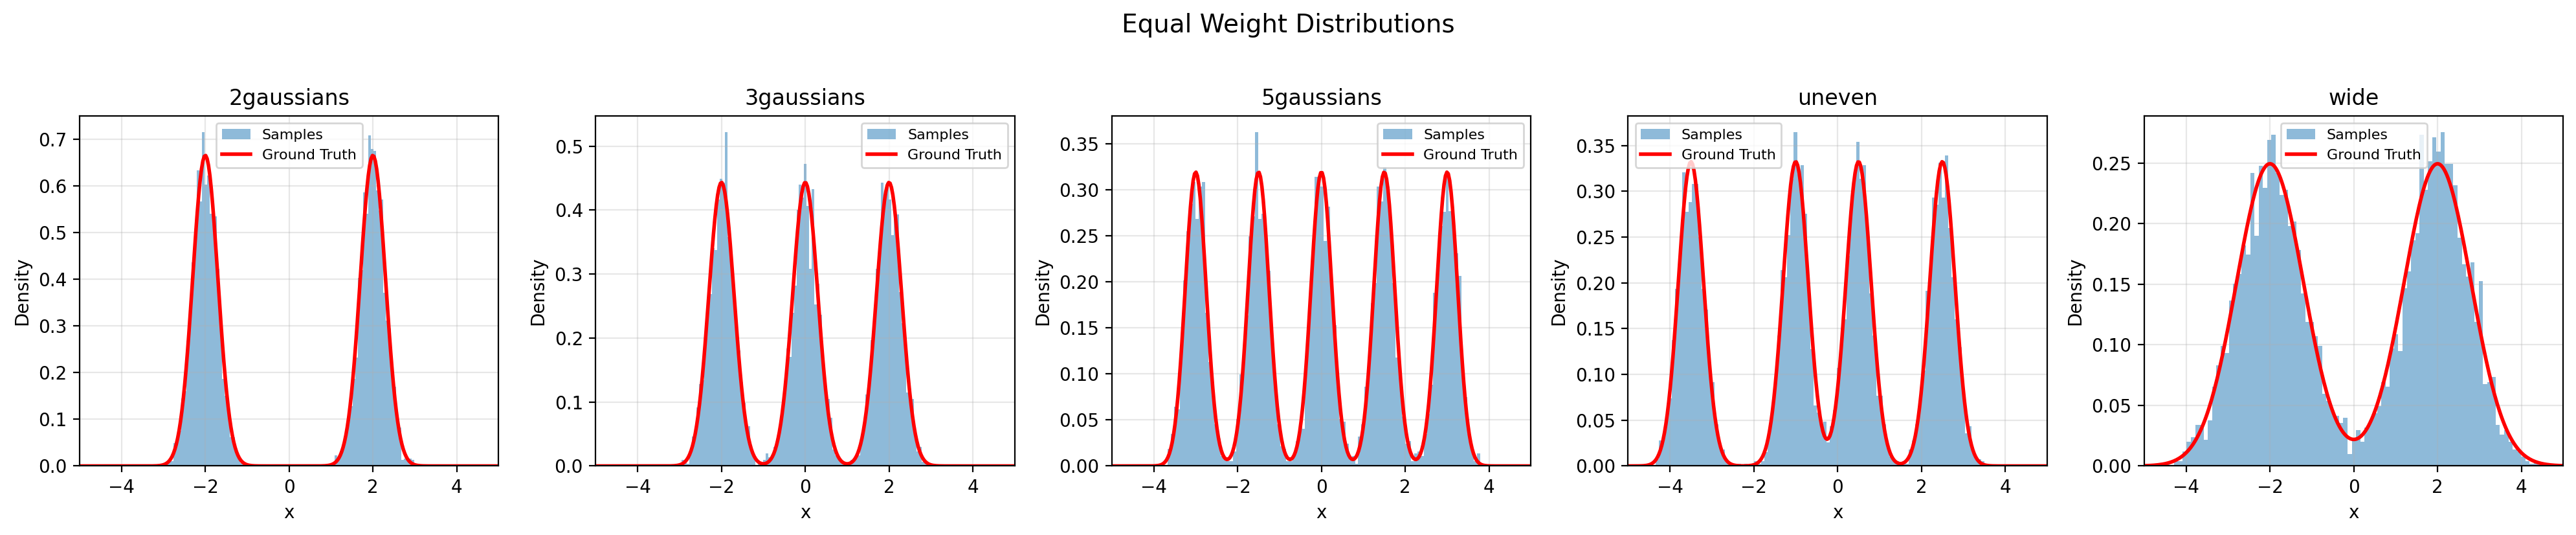

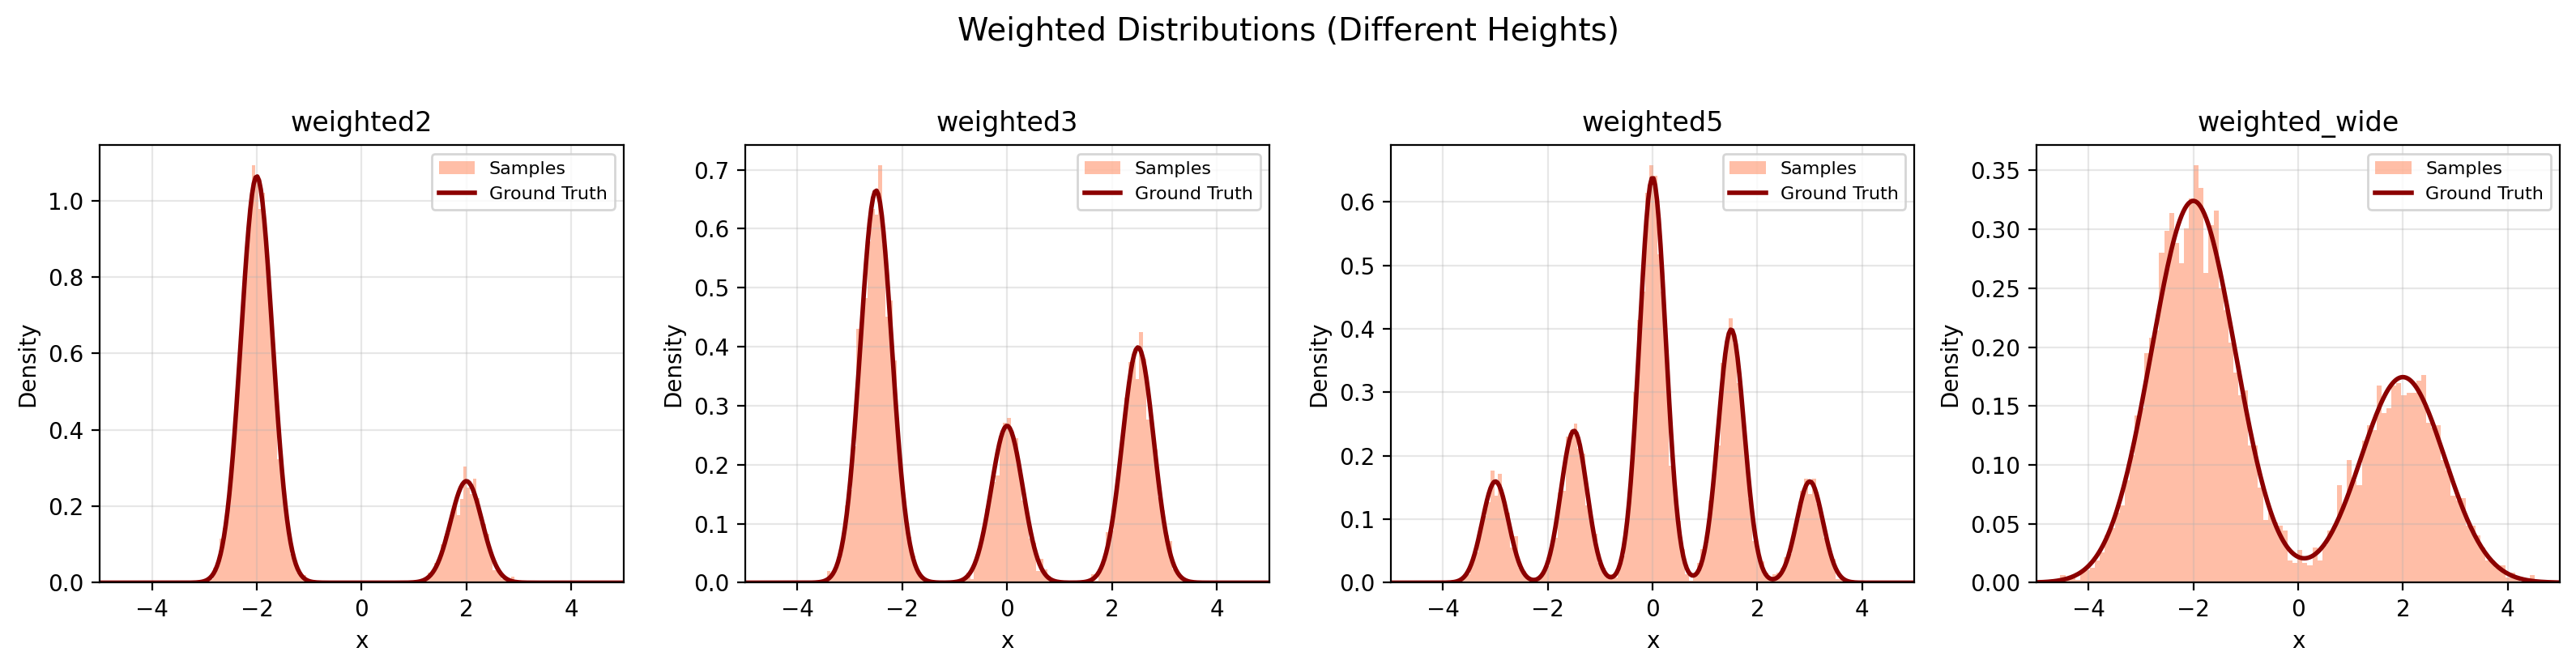

In [3]:
# Visualize available distributions
datasets_equal = ['2gaussians', '3gaussians', '5gaussians', 'uneven', 'wide']
datasets_weighted = ['weighted2', 'weighted3', 'weighted5', 'weighted_wide']

# Plot equal weight distributions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Equal Weight Distributions', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_equal):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'r-', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# Plot weighted distributions
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Weighted Distributions (Different Heights)', fontsize=14, y=1.02)
for ax, name in zip(axes, datasets_weighted):
    data = get_1d_data(name, n_samples=5000)
    ax.hist(data.numpy(), bins=100, density=True, alpha=0.5, color='coral', label='Samples')
    
    # Overlay ground truth
    x_line = np.linspace(-5, 5, 300)
    density = get_ground_truth_density(name, x_line)
    ax.plot(x_line, density, 'darkred', linewidth=2, label='Ground Truth')
    
    ax.set_title(name)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 2. Simple network for 1D

First design a simple network (like an MLP) to model the 1D data, remember to also include the time embeddings.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_hidden_layers):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

## 3. DDPM algorithm implementation

Implement the forward process, backward process, loss calculation and the sampling process of the DDPM algorithm. You can feel free to follow the structure of src/methods/ddpm.py or directly import your implementation from there.

## 4. Training

Write your training loop here (or you can combine it above, whichever way is easier for you)

In [10]:
# TODO

## 5. Visualize Samples

Visualize your learned distributions and compare them with the ground truth. I have left my visualization results for you as reference.

In [11]:
# TODO

## 6. Visualize Sampling Trajectories

Besides visualizing the final results, you can also visualize the entire sampling trajectory in order to get a better understanding of the process. Here I also left you my visualization results as an example.

In [12]:
def plot_trajectory(trajectory, title, n_points=1000, n_steps_show=10, dataset_name=None):
    """Plot sampling trajectory."""
    n_total_steps = len(trajectory)
    step_indices = np.linspace(0, n_total_steps-1, n_steps_show, dtype=int)
    
    fig, axes = plt.subplots(1, n_steps_show, figsize=(2*n_steps_show, 3))
    
    # Prepare ground truth for final step if dataset name provided
    if dataset_name is not None:
        x_line = np.linspace(-5, 5, 300)
        gt_density = get_ground_truth_density(dataset_name, x_line)
    
    for ax, step_idx in zip(axes, step_indices):
        points = trajectory[step_idx][:n_points]
        ax.hist(points.numpy(), bins=50, density=True, alpha=0.7)
        
        # Overlay ground truth on final step
        if dataset_name is not None and step_idx == step_indices[-1]:
            ax.plot(x_line, gt_density, 'r-', linewidth=2, alpha=0.8)
        
        ax.set_xlim(-5, 5)
        ax.set_ylim(0, 1.2)
        ax.set_title(f't={step_idx}', fontsize=10)
        ax.set_xlabel('x', fontsize=8)
        if ax == axes[0]:
            ax.set_ylabel('Density', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()